# ECG Alarm Forecasting
***
The data used in this notebook is a preprocessed dataset from 2017-05-25 hospital data, including timestamp, ECG signal, Pleth signal, Non-invasive Blood Pressure, SpO2, heart rate, respiration rate, alarm type and qos value. The complete feature list in the raw data is as follows:
- **Timestamp**: time with milliseconds precision. Format: *yyyy-mm-ddThh:mm:ss.xxx*
- **ECG**: Electrocardiography, recorded electrical activity of the heart Format: *a list of values*
- **Respiration Rate**: 
- **SpO2**: peripheral capillary oxygen saturation, an estimate of the amount of oxygen in the blood, format: *a number*
- **Pleth**: Pulse signal measures oxygen saturation level. Format: *a list of values*
- **Heart Rate**: 
- **etCO2**:
- **Diastolic Blood Pressure**:
- **Systolic Blood Pressure**:
- **Mean Blood Pressure**: Average blood pressure
- **QoS**: A quality flag donotes the quality of signals, 1 represents good quality. Here we only used data with QoS = 1
- **Alarm**: Alarm type of interest. Here we only predict ECG alarm. Format: *0: no alarms, 1: ECG alarm*

In [1]:
from pandas import read_csv
from matplotlib import pyplot

# load dataset
dataset = read_csv('../../clean_data/Current_Model/ECG_avg.csv', header=0, index_col=0)
dataset.head(10)

,ECG,Respiration Rate,SpO2,Pleth,Heart Rate,etCO2,diastolic BP,systolic BP,mean BP,qos,alarms
timestamp,,,,,,,,,,,
2017-05-24T23:56:18.680000,0.00,0,96.7,0.00000,0,0,0,0,0,1,NO
2017-05-24T23:56:18.712000,0.00,0,0.0,0.00000,0,0,0,0,0,1,NO
2017-05-25T00:15:58.712000,-40.96,0,0.0,1335.12500,0,0,0,0,0,1,NO
2017-05-25T00:16:00.376000,-40.96,0,95.8,1949.37500,0,0,0,0,0,1,NO
2017-05-25T00:15:58.968000,-40.96,0,96.5,2107.78125,0,0,0,0,0,1,NO
2017-05-25T00:15:59.224000,-40.96,0,0.0,2293.62500,0,0,0,0,0,1,NO
2017-05-25T00:15:59.480000,-40.96,0,0.0,1364.28125,0,0,0,0,0,1,NO
2017-05-25T00:15:59.736000,-40.96,0,0.0,1699.09375,0,0,0,0,0,1,NO
2017-05-25T00:16:01.400000,-40.96,0,96.1,2474.81250,0,0,0,0,0,1,NO


We can create a quick plot of each series and see what we have.

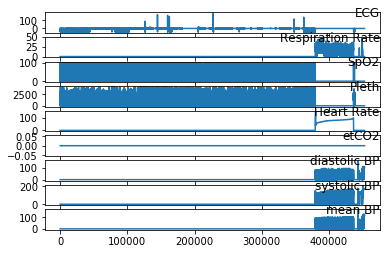

In [2]:
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5, 6, 7, 8]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

## Multivariate LSTM Forecast Model
In this section, we will fit an LSTM to the problem.

### LSTM Data Preparation
The first step is to prepare the pollution dataset for the LSTM.

This involves framing the dataset as a supervised learning problem and normalizing the input variables.

We will frame the supervised learning problem as **predicting the alarm at the current timestamp (t) given the medical measurement at the prior timestamp**. This formulation is straighforward and just for this naive demonstration. 

The *series_to_supervised()* function developed below is used to transform the dataset.

In [3]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# integer encode direction
encoder = LabelEncoder()
values[:,10] = encoder.fit_transform(values[:,10])

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[11,12,13,14,15,16,17,18,19,20]], axis=1, inplace=True)
# alarms2 = sorted(reframed["var11(t)"].unique())
# alarms1 = sorted(reframed["var11(t-1)"].unique())
# print(alarms1)
# print(alarms2)
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var11(t)
1,0.186481,0.0,0.967,0.000000,0.0,0.0,0.000000,0.000000,0.000,0.0,1.0,1.0
2,0.186481,0.0,0.000,0.000000,0.0,0.0,0.000000,0.000000,0.000,0.0,1.0,1.0
3,0.000000,0.0,0.000,0.326117,0.0,0.0,0.000000,0.000000,0.000,0.0,1.0,1.0
4,0.000000,0.0,0.958,0.476154,0.0,0.0,0.000000,0.000000,0.000,0.0,1.0,1.0
5,0.000000,0.0,0.965,0.514846,0.0,0.0,0.000000,0.000000,0.000,0.0,1.0,1.0
6,0.000000,0.0,0.000,0.560241,0.0,0.0,0.000000,0.000000,0.000,0.0,1.0,1.0
7,0.000000,0.0,0.000,0.333239,0.0,0.0,0.000000,0.000000,0.000,0.0,1.0,1.0
8,0.000000,0.0,0.000,0.415020,0.0,0.0,0.000000,0.000000,0.000,0.0,1.0,1.0
9,0.000000,0.0,0.961,0.604497,0.0,0.0,0.000000,0.000000,0.000,0.0,1.0,1.0
10,0.000000,0.0,0.963,0.643510,0.0,0.0,0.000000,0.000000,0.000,0.0,1.0,1.0


This data preparation is simple and there is more we could explore. For example,
- One-hot encoding alarm.
- Providing more than 1 input timestamp.

This last point is perhaps the most important given the use of Backpropagation through time by LSTMs when learning sequence prediction problems.

### Define and Fit Model
In this section, we will fit an LSTM on the multivariate input data.

First, we must split the prepared dataset into train and test sets. We will fit the model on the first 3000 timestamps of  data, then evaluate it on the remaining near 2000 timestamps of data.  Then splits the train and test sets into input and output variables. Finally, the inputs (X) are reshaped into the 3D format expected by LSTMs, namely [samples, timesteps, features].

In [17]:
import numpy as np
# split into train and test sets
values = reframed.values
n_train = int(len(values) * 0.8)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(362324, 1, 11) (362324,) (90581, 1, 11) (90581,)


Now we can define and fit our LSTM model.

We will define the LSTM with 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting alarm. The input shape will be 1 time step with 11 features.

We will use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.

The model will be fit for 50 training epochs with a batch size of 72. Remember that the internal state of the LSTM in Keras is reset at the end of each batch, so an internal state that is a function of a number of days may be helpful (try testing this).

Finally, we keep track of both the training and test loss during training by setting the validation_data argument in the fit() function. At the end of the run both the training and test loss are plotted.

Train on 362324 samples, validate on 90581 samples
Epoch 1/10
 - 33s - loss: 5.2812e-04 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 0.9999
Epoch 2/10
 - 29s - loss: 5.2812e-04 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 0.9999
Epoch 3/10
 - 31s - loss: 5.2812e-04 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 0.9999
Epoch 4/10
 - 26s - loss: 5.2812e-04 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 0.9999
Epoch 5/10
 - 29s - loss: 5.2812e-04 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 0.9999
Epoch 6/10
 - 29s - loss: 5.2812e-04 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 0.9999
Epoch 7/10
 - 33s - loss: 5.2812e-04 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 0.9999
Epoch 8/10
 - 31s - loss: 5.2812e-04 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 0.9999
Epoch 9/10
 - 30s - loss: 5.2812e-04 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 0.9999
Epoch 10/10
 - 32s - loss: 5.2812e-04 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 0.9999


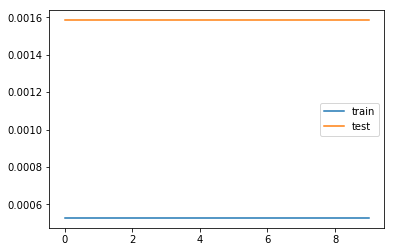

In [18]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
# fit network
history = model.fit(train_X, train_y, epochs=10, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### Evaluate Model
After the model is fit, we can forecast for the entire test dataset.

In [ ]:
score = model.evaluate(test_X, test_y, batch_size=50)

In [19]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
# make a prediction
yhat = model.predict(test_X)
# test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# # invert scaling for forecast
# inv_yhat = np.concatenate((test_X[:, 1:], yhat), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:,-1]
# # invert scaling for actual
# test_y = test_y.reshape((len(test_y), 1))
# inv_y = np.concatenate((test_X[:, 1:], test_y), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,-1]
# # calculate RMSE
# rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
# print('Test RMSE: %.3f' % rmse)

In [20]:
yhat

array([[ 1.],
       [ 1.],
       [ 1.],
       ..., 
       [ 1.],
       [ 1.],
       [ 1.]], dtype=float32)

In [21]:
accuracy_score(yhat, test_y)

0.99990064141486623